### **BiN-TABL**

In [1]:
# load packages
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix)
from torch.utils import data

if 'ipykernel' in sys.modules and False:
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SAVE_FILE_PATH = './best_model_BiNCTABL'

### **Data**
The dataset used is the LI-2010 dataset. 

As in the original paper I used the first 7 days to train and to validate, and the rest 3 days to do the the testing. 

In [3]:
# please change the data_path to your local path and download the free dataset

dec_data = np.loadtxt('./BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.txt')
dec_train = dec_data[:, :int(dec_data.shape[1] * 0.8)]
dec_val = dec_data[:, int(dec_data.shape[1] * 0.8):]

dec_test1 = np.loadtxt('./BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_7.txt')
dec_test2 = np.loadtxt('./BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_8.txt')
dec_test3 = np.loadtxt('./BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

h = 2        
dim = 10

y_train = dec_train[-h, :].flatten()
y_val = dec_val[-h, :].flatten()
y_test = dec_test[-h, :].flatten()

y_train = y_train[dim-1:] - 1
y_val = y_val[dim-1:] - 1
y_test = y_test[dim-1:] - 1 

dec_train = dec_train[:40, :].T
dec_val = dec_val[:40, :].T
dec_test = dec_test[:40, :].T

print(dec_train.shape)


(203800, 40)


In [4]:
#Computing weights for the weighted cross entropy loss
def compute_weights(y):
  cont_0 = 0
  cont_1 = 0
  cont_2 = 0
  for i in range(y.shape[0]):
    if (y[i] == 0):
      cont_0 += 1
    elif (y[i] == 1):
      cont_1 += 1
    elif (y[i] == 2):
      cont_2 += 2
    else: 
      raise Exception("wrong labels")
  return torch.Tensor([1e6/cont_0, 1e6/cont_1, 1e6/cont_2]).to(device)

y_total = np.concatenate((y_train, y_val, y_test))
weights = compute_weights(y_total)

In [5]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x, y, num_classes, dim):
        """Initialization""" 
        self.num_classes = num_classes
        self.dim = dim
        self.x = x   
        self.y = y

        self.length = x.shape[0] - (T/10) -self.dim + 1
        print(self.length)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return int(self.length)

    def __getitem__(self, i):
        input = self.x[i:i+self.dim, :]
        input = input.permute(1, 2, 0)
        input = torch.squeeze(input)

        return input, self.y[i]

In [6]:
#Hyperparameters

batch_size = 256
epochs = 100
T = 50   #horizon    
lr = 0.001
num_classes = 3

dataset_val = Dataset(dec_val, y_val, num_classes, dim)
dataset_test = Dataset(dec_test, y_test, num_classes, dim)
dataset_train = Dataset(dec_train, y_train, num_classes, dim)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

50936.0
139573.0
203786.0


### **Model Architecture**
The architecture is explained in the original paper

In [7]:
class TABL_layer(nn.Module):
    def __init__(self, d2, d1, t1, t2):
        super().__init__()
        self.t1 = t1

        weight = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')
        
        weight2 = torch.Tensor(t1, t1)
        self.W = nn.Parameter(weight2)
        nn.init.constant_(self.W, 1/t1)
 
        weight3 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight3)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.Tensor(d2, t2)
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        l = torch.Tensor(1,)
        self.l = nn.Parameter(l)
        nn.init.constant_(self.l, 0.5)

        self.activation = nn.ReLU()

    def forward(self, X):
        
        #maintaining the weight parameter between 0 and 1.
        if (self.l[0] < 0): 
          l = torch.Tensor(1,).to(device)
          self.l = nn.Parameter(l)
          nn.init.constant_(self.l, 0.0)

        if (self.l[0] > 1): 
          l = torch.Tensor(1,).to(device)
          self.l = nn.Parameter(l)
          nn.init.constant_(self.l, 1.0)
     
        #modelling the dependence along the first mode of X while keeping the temporal order intact (7)
        X = self.W1 @ X

        #enforcing constant (1) on the diagonal
        W = self.W -self.W *torch.eye(self.t1,dtype=torch.float32).to(device)+torch.eye(self.t1,dtype=torch.float32).to(device)/self.t1

        #attention, the aim of the second step is to learn how important the temporal instances are to each other (8)
        E = X @ W

        #computing the attention mask  (9)
        A = torch.softmax(E, dim=-1)

        #applying a soft attention mechanism  (10)
        #he attention mask A obtained from the third step is used to zero out the effect of unimportant elements
        X = self.l[0] * (X) + (1.0 - self.l[0])*X*A

        #the final step of the proposed layer estimates the temporal mapping W2, after the bias shift (11)
        y = X @ self.W2 + self.B
        return y

class BL_layer(nn.Module):
  def __init__(self, d2, d1, t1, t2):
        super().__init__()
        weight1 = torch.Tensor(d2, d1)
        self.W1 = nn.Parameter(weight1)
        nn.init.kaiming_uniform_(self.W1, nonlinearity='relu')

        weight2 = torch.Tensor(t1, t2)
        self.W2 = nn.Parameter(weight2)
        nn.init.kaiming_uniform_(self.W2, nonlinearity='relu')

        bias1 = torch.zeros((d2, t2))
        self.B = nn.Parameter(bias1)
        nn.init.constant_(self.B, 0)

        self.activation = nn.ReLU()

  def forward(self, x):

    x = self.activation(self.W1 @ x @ self.W2 + self.B)

    return x

In [8]:
import math

class BiN(nn.Module):
  def __init__(self, d1, t1):
        super().__init__()
        self.t1 = t1
        self.d1 = d1

        bias1 = torch.Tensor(t1,1)
        self.B1 = nn.Parameter(bias1)
        nn.init.constant_(self.B1, 0)

        l1 = torch.Tensor(t1,1)
        self.l1 = nn.Parameter(l1)
        nn.init.xavier_normal_(self.l1)     

        bias2 = torch.Tensor(d1,1)
        self.B2 = nn.Parameter(bias2)
        nn.init.constant_(self.B2, 0)

        l2 = torch.Tensor(d1,1)
        self.l2 = nn.Parameter(l2)
        nn.init.xavier_normal_(self.l2)      

        y1 = torch.Tensor(1,)
        self.y1 = nn.Parameter(y1)
        nn.init.constant_(self.y1, 0.5)

        y2 = torch.Tensor(1,)
        self.y2 = nn.Parameter(y2)
        nn.init.constant_(self.y2, 0.5)

  def forward(self, x):

    #if the two scalars are negative then we setting them to 0
    if (self.y1[0] < 0): 
        y1 = torch.Tensor(1,).to(device)
        self.y1 = nn.Parameter(y1)
        nn.init.constant_(self.y1, 0.01)

    if (self.y2[0] < 0): 
        y2 = torch.Tensor(1,).to(device)
        self.y2 = nn.Parameter(y2)
        nn.init.constant_(self.y2, 0.01)

    #normalization along the temporal dimensione 
    T2 = torch.ones([self.t1, 1]).to(device)
    x2 = torch.mean(x, axis=2).to(device) 
    x2 = torch.reshape(x2, (x2.shape[0], x2.shape[1], 1))

    std = torch.std(x, axis=2)
    std = torch.reshape(std, (std.shape[0], std.shape[1], 1))

    #it can be possible that the std of some temporal slices is 0, and this produces inf values, so we have to set them to one
    std[std < 1e-4] = 1            

    diff = x - (x2@(T2.T))
    Z2 = diff / (std@(T2.T))

    X2 = self.l2 @ T2.T
    X2 = X2 * Z2
    X2 = X2 + (self.B2 @ T2.T)   

    #normalization along the feature dimension
    T1 = torch.ones([self.d1, 1]).to(device)
    x1 = torch.mean(x, axis=1) 
    x1 = torch.reshape(x1, (x1.shape[0], x1.shape[1], 1))

    std = torch.std(x, axis=1)
    std = torch.reshape(std, (std.shape[0], std.shape[1], 1))

    op1 = x1@T1.T
    op1 = torch.permute(op1, (0, 2, 1))

    op2 = std@T1.T
    op2 = torch.permute(op2, (0, 2, 1))
    
    z1 = (x - op1) / (op2)
    X1 = (T1 @ self.l1.T)
    X1 = X1 * z1 
    X1 = X1 + (T1 @ self.B1.T)

    #weighing the imporance of temporal and feature normalization
    x = self.y1*X1 + self.y2*X2
    
    return x

In [9]:
class BiN_BTABL(nn.Module):
  def __init__(self, d2, d1, t1, t2, d3, t3):
    super().__init__()

    self.BiN = BiN(d2, d1, t1, t2)
    self.BL = BL_layer(d2, d1, t1, t2)
    self.TABL = TABL_layer(d3, d2, t2, t3)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
    #first of all we pass the input to the BiN layer, then we use the B(TABL) architecture
    x = self.BiN(x)

    self.max_norm_(self.BL.W1.data)
    self.max_norm_(self.BL.W2.data)
    x = self.BL(x)
    x = self.dropout(x)

    self.max_norm_(self.TABL.W1.data)
    self.max_norm_(self.TABL.W.data)
    self.max_norm_(self.TABL.W2.data)
    x = self.TABL(x)
    x = torch.squeeze(x)
    x = torch.softmax(x, 1)


    return x

  def max_norm_(self, w):
    with torch.no_grad():
      if (torch.linalg.matrix_norm(w) > 10.0):
        norm = torch.linalg.matrix_norm(w)
        desired = torch.clamp(norm, min=0.0, max=10.0)
        w *= (desired / (1e-8 + norm))


class BiN_CTABL(nn.Module):
  def __init__(self, d2, d1, t1, t2, d3, t3, d4, t4):
    super().__init__()

    # TODO: TBRB
    #self.BiN = BiN(d2, d1, t1, t2)
    self.BiN = BiN(d1, t1)
    # TODO: TBRB
    self.BL = BL_layer(d2, d1, t1, t2)
    self.BL2 = BL_layer(d3, d2, t2, t3)
    self.TABL = TABL_layer(d4, d3, t3, t4)
    self.dropout = nn.Dropout(0.1)

  def forward(self, x):
    #first of all we pass the input to the BiN layer, then we use the C(TABL) architecture
    x = self.BiN(x)

    self.max_norm_(self.BL.W1.data)
    self.max_norm_(self.BL.W2.data)
    x = self.BL(x)
    x = self.dropout(x)
    
    self.max_norm_(self.BL2.W1.data)
    self.max_norm_(self.BL2.W2.data)
    x = self.BL2(x)
    x = self.dropout(x)

    self.max_norm_(self.TABL.W1.data)
    self.max_norm_(self.TABL.W.data)
    self.max_norm_(self.TABL.W2.data)
    x = self.TABL(x)
    x = torch.squeeze(x, -1)
    x = torch.softmax(x, 1)
    
    return x

  def max_norm_(self, w):
    with torch.no_grad():
      if (torch.linalg.matrix_norm(w) > 10.0):
        norm = torch.linalg.matrix_norm(w)
        desired = torch.clamp(norm, min=0.0, max=10.0)
        w *= (desired / (1e-8 + norm))   
    

### **Model Training**

In [10]:
#you can choose between the two architectures

#model = BiN_BTABL(120, 40, 10, 5, 3, 1)
model = BiN_CTABL(60, 40, 10, 10, 120, 5, 3, 1)

model.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-3)


def batch_gd(model, criterion, optimizer, epochs):
    
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0
    
    for it in tqdm(range(epochs)):
        
        #as written in the paper we change the lr at the 11 and 71 epochs
        if (it == 10):
              for g in optimizer.param_groups:
                g['lr'] = 0.0001

        if (it == 70):
          for g in optimizer.param_groups:
                g['lr'] = 0.00001

        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:

            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float32), targets.to(device, dtype=torch.int64)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            #computing the error
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
        # Get train loss and test loss
        train_loss = np.mean(train_loss)
        model.eval()
        
        test_loss = []
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        #We save the best model
        if test_loss < best_test_loss:
            torch.save(model, SAVE_FILE_PATH)
            best_test_loss = test_loss
            best_test_epoch = it
            print('model saved')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')
        
    #torch.save(model, '/content/drive/MyDrive/Output/best_model_translob_FI')
    return train_losses, test_losses

------- List Hyper Parameters -------
epochs   ->   100
learningRate   ->   0.001
horizon    ->     50
batch size   ->    256
Optimizer   ->    Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.001
)


  1%|          | 1/100 [00:16<26:45, 16.21s/it]

model saved
Epoch 1/100, Train Loss: 0.7549,           Validation Loss: 0.6870, Duration: 0:00:16.214983, Best Val Epoch: 0


  2%|▏         | 2/100 [00:33<27:28, 16.82s/it]

model saved
Epoch 2/100, Train Loss: 0.6924,           Validation Loss: 0.6819, Duration: 0:00:17.243563, Best Val Epoch: 1


  3%|▎         | 3/100 [00:50<27:26, 16.97s/it]

model saved
Epoch 3/100, Train Loss: 0.6886,           Validation Loss: 0.6814, Duration: 0:00:17.147798, Best Val Epoch: 2


  4%|▍         | 4/100 [01:07<27:08, 16.97s/it]

model saved
Epoch 4/100, Train Loss: 0.6879,           Validation Loss: 0.6807, Duration: 0:00:16.962442, Best Val Epoch: 3


  5%|▌         | 5/100 [01:24<26:50, 16.95s/it]

model saved
Epoch 5/100, Train Loss: 0.6874,           Validation Loss: 0.6798, Duration: 0:00:16.920475, Best Val Epoch: 4


  6%|▌         | 6/100 [01:41<26:29, 16.91s/it]

Epoch 6/100, Train Loss: 0.6869,           Validation Loss: 0.6803, Duration: 0:00:16.834651, Best Val Epoch: 4


  7%|▋         | 7/100 [01:58<26:16, 16.95s/it]

model saved
Epoch 7/100, Train Loss: 0.6871,           Validation Loss: 0.6795, Duration: 0:00:17.022846, Best Val Epoch: 6


  8%|▊         | 8/100 [02:15<26:03, 16.99s/it]

model saved
Epoch 8/100, Train Loss: 0.6871,           Validation Loss: 0.6791, Duration: 0:00:17.089510, Best Val Epoch: 7


  9%|▉         | 9/100 [02:32<25:43, 16.96s/it]

model saved
Epoch 9/100, Train Loss: 0.6870,           Validation Loss: 0.6789, Duration: 0:00:16.885062, Best Val Epoch: 8


 10%|█         | 10/100 [02:49<25:27, 16.97s/it]

model saved
Epoch 10/100, Train Loss: 0.6869,           Validation Loss: 0.6787, Duration: 0:00:16.996599, Best Val Epoch: 9


 11%|█         | 11/100 [03:06<25:12, 16.99s/it]

model saved
Epoch 11/100, Train Loss: 0.6859,           Validation Loss: 0.6787, Duration: 0:00:17.030236, Best Val Epoch: 10


 12%|█▏        | 12/100 [03:23<24:54, 16.98s/it]

Epoch 12/100, Train Loss: 0.6862,           Validation Loss: 0.6790, Duration: 0:00:16.948154, Best Val Epoch: 10


 13%|█▎        | 13/100 [03:40<24:40, 17.02s/it]

model saved
Epoch 13/100, Train Loss: 0.6859,           Validation Loss: 0.6785, Duration: 0:00:17.101810, Best Val Epoch: 12


 14%|█▍        | 14/100 [03:57<24:33, 17.13s/it]

Epoch 14/100, Train Loss: 0.6860,           Validation Loss: 0.6786, Duration: 0:00:17.403760, Best Val Epoch: 12


 15%|█▌        | 15/100 [04:15<24:22, 17.20s/it]

model saved
Epoch 15/100, Train Loss: 0.6860,           Validation Loss: 0.6784, Duration: 0:00:17.369320, Best Val Epoch: 14


 16%|█▌        | 16/100 [04:32<24:07, 17.23s/it]

model saved
Epoch 16/100, Train Loss: 0.6859,           Validation Loss: 0.6784, Duration: 0:00:17.288018, Best Val Epoch: 15


 17%|█▋        | 17/100 [04:49<23:48, 17.21s/it]

Epoch 17/100, Train Loss: 0.6861,           Validation Loss: 0.6786, Duration: 0:00:17.175740, Best Val Epoch: 15


 18%|█▊        | 18/100 [05:06<23:30, 17.20s/it]

Epoch 18/100, Train Loss: 0.6858,           Validation Loss: 0.6786, Duration: 0:00:17.158347, Best Val Epoch: 15


 19%|█▉        | 19/100 [05:23<22:52, 16.95s/it]

Epoch 19/100, Train Loss: 0.6861,           Validation Loss: 0.6786, Duration: 0:00:16.371264, Best Val Epoch: 15


 20%|██        | 20/100 [05:40<22:33, 16.92s/it]

model saved
Epoch 20/100, Train Loss: 0.6858,           Validation Loss: 0.6784, Duration: 0:00:16.839568, Best Val Epoch: 19


 21%|██        | 21/100 [05:57<22:18, 16.94s/it]

Epoch 21/100, Train Loss: 0.6858,           Validation Loss: 0.6785, Duration: 0:00:16.995023, Best Val Epoch: 19


 22%|██▏       | 22/100 [06:13<21:53, 16.84s/it]

Epoch 22/100, Train Loss: 0.6861,           Validation Loss: 0.6790, Duration: 0:00:16.619290, Best Val Epoch: 19


 23%|██▎       | 23/100 [06:30<21:28, 16.74s/it]

Epoch 23/100, Train Loss: 0.6857,           Validation Loss: 0.6784, Duration: 0:00:16.487008, Best Val Epoch: 19


 24%|██▍       | 24/100 [06:46<21:09, 16.71s/it]

Epoch 24/100, Train Loss: 0.6856,           Validation Loss: 0.6790, Duration: 0:00:16.636555, Best Val Epoch: 19


 25%|██▌       | 25/100 [07:03<20:49, 16.67s/it]

Epoch 25/100, Train Loss: 0.6857,           Validation Loss: 0.6785, Duration: 0:00:16.569015, Best Val Epoch: 19


 26%|██▌       | 26/100 [07:19<20:31, 16.64s/it]

Epoch 26/100, Train Loss: 0.6858,           Validation Loss: 0.6786, Duration: 0:00:16.567368, Best Val Epoch: 19


 27%|██▋       | 27/100 [07:36<20:12, 16.60s/it]

Epoch 27/100, Train Loss: 0.6855,           Validation Loss: 0.6786, Duration: 0:00:16.525538, Best Val Epoch: 19


 28%|██▊       | 28/100 [07:53<19:56, 16.62s/it]

Epoch 28/100, Train Loss: 0.6858,           Validation Loss: 0.6784, Duration: 0:00:16.663558, Best Val Epoch: 19


 29%|██▉       | 29/100 [08:09<19:37, 16.59s/it]

model saved
Epoch 29/100, Train Loss: 0.6856,           Validation Loss: 0.6783, Duration: 0:00:16.516942, Best Val Epoch: 28


 30%|███       | 30/100 [08:26<19:23, 16.62s/it]

Epoch 30/100, Train Loss: 0.6857,           Validation Loss: 0.6785, Duration: 0:00:16.680185, Best Val Epoch: 28


 31%|███       | 31/100 [08:42<19:07, 16.62s/it]

Epoch 31/100, Train Loss: 0.6859,           Validation Loss: 0.6789, Duration: 0:00:16.640989, Best Val Epoch: 28


 32%|███▏      | 32/100 [08:59<18:50, 16.62s/it]

model saved
Epoch 32/100, Train Loss: 0.6858,           Validation Loss: 0.6783, Duration: 0:00:16.613249, Best Val Epoch: 31


 33%|███▎      | 33/100 [09:16<18:37, 16.67s/it]

Epoch 33/100, Train Loss: 0.6858,           Validation Loss: 0.6786, Duration: 0:00:16.796773, Best Val Epoch: 31


 34%|███▍      | 34/100 [09:33<18:20, 16.68s/it]

Epoch 34/100, Train Loss: 0.6857,           Validation Loss: 0.6783, Duration: 0:00:16.680279, Best Val Epoch: 31


 35%|███▌      | 35/100 [09:49<18:04, 16.68s/it]

Epoch 35/100, Train Loss: 0.6860,           Validation Loss: 0.6784, Duration: 0:00:16.692984, Best Val Epoch: 31


 36%|███▌      | 36/100 [10:06<17:49, 16.71s/it]

model saved
Epoch 36/100, Train Loss: 0.6857,           Validation Loss: 0.6782, Duration: 0:00:16.777182, Best Val Epoch: 35


 37%|███▋      | 37/100 [10:23<17:33, 16.72s/it]

Epoch 37/100, Train Loss: 0.6858,           Validation Loss: 0.6788, Duration: 0:00:16.744282, Best Val Epoch: 35


 38%|███▊      | 38/100 [10:39<17:16, 16.72s/it]

Epoch 38/100, Train Loss: 0.6855,           Validation Loss: 0.6783, Duration: 0:00:16.722780, Best Val Epoch: 35


 39%|███▉      | 39/100 [10:56<16:59, 16.71s/it]

Epoch 39/100, Train Loss: 0.6858,           Validation Loss: 0.6783, Duration: 0:00:16.666366, Best Val Epoch: 35


 40%|████      | 40/100 [11:13<16:41, 16.70s/it]

Epoch 40/100, Train Loss: 0.6856,           Validation Loss: 0.6785, Duration: 0:00:16.675300, Best Val Epoch: 35


 41%|████      | 41/100 [11:30<16:27, 16.73s/it]

Epoch 41/100, Train Loss: 0.6859,           Validation Loss: 0.6785, Duration: 0:00:16.819425, Best Val Epoch: 35


 42%|████▏     | 42/100 [11:46<16:11, 16.76s/it]

Epoch 42/100, Train Loss: 0.6855,           Validation Loss: 0.6783, Duration: 0:00:16.804134, Best Val Epoch: 35


 43%|████▎     | 43/100 [12:03<15:53, 16.74s/it]

Epoch 43/100, Train Loss: 0.6858,           Validation Loss: 0.6783, Duration: 0:00:16.691950, Best Val Epoch: 35


 44%|████▍     | 44/100 [12:20<15:36, 16.73s/it]

Epoch 44/100, Train Loss: 0.6858,           Validation Loss: 0.6784, Duration: 0:00:16.715928, Best Val Epoch: 35


 45%|████▌     | 45/100 [12:37<15:20, 16.73s/it]

Epoch 45/100, Train Loss: 0.6855,           Validation Loss: 0.6787, Duration: 0:00:16.721434, Best Val Epoch: 35


 46%|████▌     | 46/100 [12:53<15:02, 16.71s/it]

Epoch 46/100, Train Loss: 0.6857,           Validation Loss: 0.6784, Duration: 0:00:16.668182, Best Val Epoch: 35


 47%|████▋     | 47/100 [13:10<14:45, 16.71s/it]

Epoch 47/100, Train Loss: 0.6856,           Validation Loss: 0.6785, Duration: 0:00:16.713495, Best Val Epoch: 35


 48%|████▊     | 48/100 [13:27<14:28, 16.71s/it]

Epoch 48/100, Train Loss: 0.6857,           Validation Loss: 0.6792, Duration: 0:00:16.702114, Best Val Epoch: 35


 49%|████▉     | 49/100 [13:43<14:12, 16.72s/it]

Epoch 49/100, Train Loss: 0.6858,           Validation Loss: 0.6786, Duration: 0:00:16.755388, Best Val Epoch: 35


 50%|█████     | 50/100 [14:00<13:57, 16.75s/it]

Epoch 50/100, Train Loss: 0.6857,           Validation Loss: 0.6787, Duration: 0:00:16.799245, Best Val Epoch: 35


 51%|█████     | 51/100 [14:17<13:41, 16.76s/it]

Epoch 51/100, Train Loss: 0.6856,           Validation Loss: 0.6791, Duration: 0:00:16.786717, Best Val Epoch: 35


 52%|█████▏    | 52/100 [14:34<13:26, 16.80s/it]

model saved
Epoch 52/100, Train Loss: 0.6858,           Validation Loss: 0.6782, Duration: 0:00:16.909774, Best Val Epoch: 51


 53%|█████▎    | 53/100 [14:51<13:09, 16.81s/it]

Epoch 53/100, Train Loss: 0.6858,           Validation Loss: 0.6784, Duration: 0:00:16.812546, Best Val Epoch: 51


 54%|█████▍    | 54/100 [15:08<12:52, 16.80s/it]

Epoch 54/100, Train Loss: 0.6855,           Validation Loss: 0.6786, Duration: 0:00:16.778376, Best Val Epoch: 51


 55%|█████▌    | 55/100 [15:24<12:37, 16.83s/it]

Epoch 55/100, Train Loss: 0.6856,           Validation Loss: 0.6785, Duration: 0:00:16.896577, Best Val Epoch: 51


 56%|█████▌    | 56/100 [15:41<12:19, 16.80s/it]

Epoch 56/100, Train Loss: 0.6857,           Validation Loss: 0.6787, Duration: 0:00:16.746760, Best Val Epoch: 51


 57%|█████▋    | 57/100 [15:58<12:03, 16.83s/it]

Epoch 57/100, Train Loss: 0.6856,           Validation Loss: 0.6785, Duration: 0:00:16.890088, Best Val Epoch: 51


 58%|█████▊    | 58/100 [16:15<11:45, 16.80s/it]

Epoch 58/100, Train Loss: 0.6857,           Validation Loss: 0.6784, Duration: 0:00:16.721280, Best Val Epoch: 51


 59%|█████▉    | 59/100 [16:31<11:27, 16.78s/it]

Epoch 59/100, Train Loss: 0.6855,           Validation Loss: 0.6785, Duration: 0:00:16.735763, Best Val Epoch: 51


 60%|██████    | 60/100 [16:48<11:11, 16.79s/it]

Epoch 60/100, Train Loss: 0.6858,           Validation Loss: 0.6783, Duration: 0:00:16.802062, Best Val Epoch: 51


 61%|██████    | 61/100 [17:05<10:53, 16.77s/it]

Epoch 61/100, Train Loss: 0.6857,           Validation Loss: 0.6787, Duration: 0:00:16.715275, Best Val Epoch: 51


 62%|██████▏   | 62/100 [17:22<10:37, 16.78s/it]

Epoch 62/100, Train Loss: 0.6857,           Validation Loss: 0.6788, Duration: 0:00:16.807790, Best Val Epoch: 51


 63%|██████▎   | 63/100 [17:39<10:27, 16.95s/it]

Epoch 63/100, Train Loss: 0.6858,           Validation Loss: 0.6783, Duration: 0:00:17.342345, Best Val Epoch: 51


 64%|██████▍   | 64/100 [17:57<10:15, 17.09s/it]

Epoch 64/100, Train Loss: 0.6856,           Validation Loss: 0.6784, Duration: 0:00:17.424903, Best Val Epoch: 51


 65%|██████▌   | 65/100 [18:14<10:01, 17.19s/it]

Epoch 65/100, Train Loss: 0.6854,           Validation Loss: 0.6783, Duration: 0:00:17.422733, Best Val Epoch: 51


 66%|██████▌   | 66/100 [18:31<09:45, 17.22s/it]

Epoch 66/100, Train Loss: 0.6857,           Validation Loss: 0.6783, Duration: 0:00:17.294073, Best Val Epoch: 51


 67%|██████▋   | 67/100 [18:48<09:21, 17.01s/it]

Epoch 67/100, Train Loss: 0.6854,           Validation Loss: 0.6784, Duration: 0:00:16.516753, Best Val Epoch: 51


 68%|██████▊   | 68/100 [19:04<08:54, 16.71s/it]

Epoch 68/100, Train Loss: 0.6856,           Validation Loss: 0.6784, Duration: 0:00:15.995145, Best Val Epoch: 51


 69%|██████▉   | 69/100 [19:20<08:30, 16.46s/it]

Epoch 69/100, Train Loss: 0.6858,           Validation Loss: 0.6782, Duration: 0:00:15.896316, Best Val Epoch: 51


 70%|███████   | 70/100 [19:35<08:07, 16.25s/it]

Epoch 70/100, Train Loss: 0.6857,           Validation Loss: 0.6784, Duration: 0:00:15.750214, Best Val Epoch: 51


 71%|███████   | 71/100 [19:51<07:48, 16.17s/it]

Epoch 71/100, Train Loss: 0.6854,           Validation Loss: 0.6784, Duration: 0:00:15.982262, Best Val Epoch: 51


 72%|███████▏  | 72/100 [20:07<07:30, 16.09s/it]

Epoch 72/100, Train Loss: 0.6854,           Validation Loss: 0.6783, Duration: 0:00:15.904824, Best Val Epoch: 51


 73%|███████▎  | 73/100 [20:23<07:12, 16.01s/it]

Epoch 73/100, Train Loss: 0.6854,           Validation Loss: 0.6784, Duration: 0:00:15.816467, Best Val Epoch: 51


 74%|███████▍  | 74/100 [20:39<06:54, 15.95s/it]

Epoch 74/100, Train Loss: 0.6856,           Validation Loss: 0.6784, Duration: 0:00:15.802983, Best Val Epoch: 51


 75%|███████▌  | 75/100 [20:55<06:37, 15.91s/it]

Epoch 75/100, Train Loss: 0.6856,           Validation Loss: 0.6784, Duration: 0:00:15.822269, Best Val Epoch: 51


 76%|███████▌  | 76/100 [21:11<06:22, 15.93s/it]

Epoch 76/100, Train Loss: 0.6855,           Validation Loss: 0.6784, Duration: 0:00:15.976108, Best Val Epoch: 51


 77%|███████▋  | 77/100 [21:27<06:06, 15.92s/it]

Epoch 77/100, Train Loss: 0.6853,           Validation Loss: 0.6785, Duration: 0:00:15.892606, Best Val Epoch: 51


 78%|███████▊  | 78/100 [21:42<05:49, 15.87s/it]

Epoch 78/100, Train Loss: 0.6855,           Validation Loss: 0.6784, Duration: 0:00:15.767708, Best Val Epoch: 51


 79%|███████▉  | 79/100 [21:58<05:33, 15.88s/it]

Epoch 79/100, Train Loss: 0.6855,           Validation Loss: 0.6784, Duration: 0:00:15.886859, Best Val Epoch: 51


 80%|████████  | 80/100 [22:14<05:17, 15.86s/it]

Epoch 80/100, Train Loss: 0.6853,           Validation Loss: 0.6783, Duration: 0:00:15.806284, Best Val Epoch: 51


 81%|████████  | 81/100 [22:30<05:01, 15.84s/it]

Epoch 81/100, Train Loss: 0.6855,           Validation Loss: 0.6785, Duration: 0:00:15.812513, Best Val Epoch: 51


 82%|████████▏ | 82/100 [22:46<04:45, 15.86s/it]

Epoch 82/100, Train Loss: 0.6853,           Validation Loss: 0.6783, Duration: 0:00:15.891514, Best Val Epoch: 51


 83%|████████▎ | 83/100 [23:02<04:28, 15.81s/it]

Epoch 83/100, Train Loss: 0.6854,           Validation Loss: 0.6783, Duration: 0:00:15.683786, Best Val Epoch: 51


 84%|████████▍ | 84/100 [23:17<04:13, 15.83s/it]

Epoch 84/100, Train Loss: 0.6855,           Validation Loss: 0.6784, Duration: 0:00:15.890458, Best Val Epoch: 51


 85%|████████▌ | 85/100 [23:33<03:57, 15.80s/it]

Epoch 85/100, Train Loss: 0.6855,           Validation Loss: 0.6783, Duration: 0:00:15.740107, Best Val Epoch: 51


 86%|████████▌ | 86/100 [23:49<03:41, 15.79s/it]

Epoch 86/100, Train Loss: 0.6853,           Validation Loss: 0.6784, Duration: 0:00:15.744557, Best Val Epoch: 51


 87%|████████▋ | 87/100 [24:05<03:25, 15.79s/it]

Epoch 87/100, Train Loss: 0.6855,           Validation Loss: 0.6785, Duration: 0:00:15.787432, Best Val Epoch: 51


 88%|████████▊ | 88/100 [24:20<03:09, 15.78s/it]

Epoch 88/100, Train Loss: 0.6853,           Validation Loss: 0.6785, Duration: 0:00:15.770199, Best Val Epoch: 51


 89%|████████▉ | 89/100 [24:36<02:53, 15.76s/it]

Epoch 89/100, Train Loss: 0.6855,           Validation Loss: 0.6784, Duration: 0:00:15.701758, Best Val Epoch: 51


 90%|█████████ | 90/100 [24:52<02:37, 15.79s/it]

Epoch 90/100, Train Loss: 0.6854,           Validation Loss: 0.6784, Duration: 0:00:15.870043, Best Val Epoch: 51


 91%|█████████ | 91/100 [25:08<02:21, 15.77s/it]

Epoch 91/100, Train Loss: 0.6856,           Validation Loss: 0.6785, Duration: 0:00:15.708145, Best Val Epoch: 51


 92%|█████████▏| 92/100 [25:24<02:06, 15.77s/it]

Epoch 92/100, Train Loss: 0.6855,           Validation Loss: 0.6784, Duration: 0:00:15.792873, Best Val Epoch: 51


 93%|█████████▎| 93/100 [25:39<01:50, 15.77s/it]

Epoch 93/100, Train Loss: 0.6854,           Validation Loss: 0.6783, Duration: 0:00:15.760068, Best Val Epoch: 51


 94%|█████████▍| 94/100 [25:55<01:34, 15.75s/it]

Epoch 94/100, Train Loss: 0.6856,           Validation Loss: 0.6784, Duration: 0:00:15.696846, Best Val Epoch: 51


 95%|█████████▌| 95/100 [26:11<01:18, 15.75s/it]

Epoch 95/100, Train Loss: 0.6854,           Validation Loss: 0.6784, Duration: 0:00:15.736331, Best Val Epoch: 51


 96%|█████████▌| 96/100 [26:26<01:02, 15.74s/it]

Epoch 96/100, Train Loss: 0.6854,           Validation Loss: 0.6784, Duration: 0:00:15.712768, Best Val Epoch: 51


 97%|█████████▋| 97/100 [26:42<00:47, 15.76s/it]

Epoch 97/100, Train Loss: 0.6856,           Validation Loss: 0.6783, Duration: 0:00:15.805472, Best Val Epoch: 51


 98%|█████████▊| 98/100 [26:58<00:31, 15.77s/it]

Epoch 98/100, Train Loss: 0.6856,           Validation Loss: 0.6784, Duration: 0:00:15.786532, Best Val Epoch: 51


 99%|█████████▉| 99/100 [27:14<00:15, 15.76s/it]

Epoch 99/100, Train Loss: 0.6852,           Validation Loss: 0.6784, Duration: 0:00:15.743540, Best Val Epoch: 51


100%|██████████| 100/100 [27:30<00:00, 16.50s/it]

Epoch 100/100, Train Loss: 0.6853,           Validation Loss: 0.6784, Duration: 0:00:15.815585, Best Val Epoch: 51


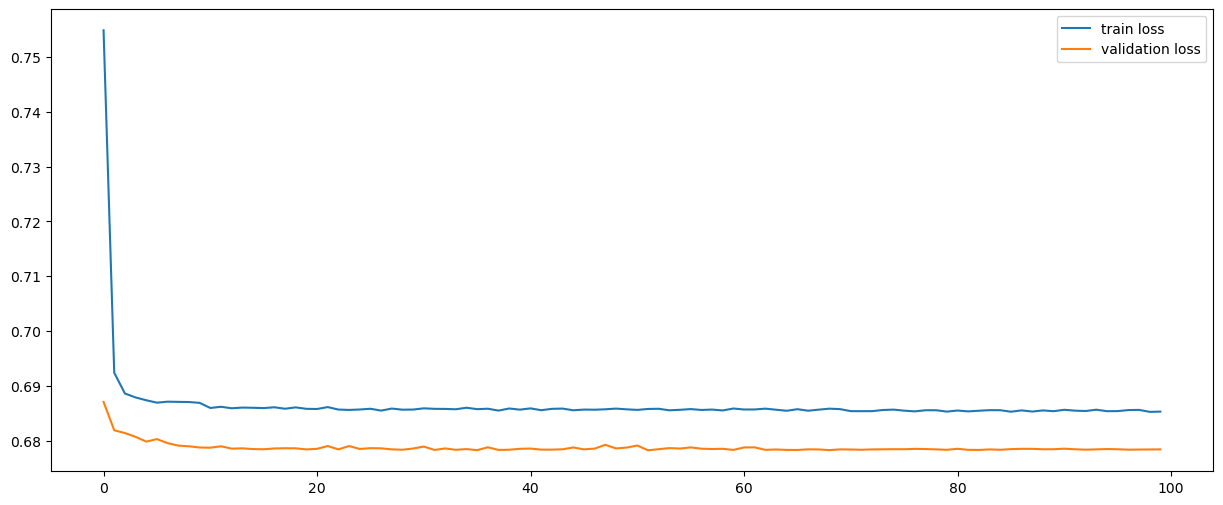

In [11]:
print("------- List Hyper Parameters -------")
print("epochs   ->   " + str(epochs))
print("learningRate   ->   " + str(lr))
print("horizon    ->     " + str(T))
print("batch size   ->    " + str(batch_size))
print("Optimizer   ->    " + str(optimizer))

train_losses, val_losses = batch_gd(model, criterion, optimizer, 
                                     epochs)

plt.figure(figsize=(15,6))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

### **Model Testing**

In [12]:
# test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=1, shuffle=False)
#model = torch.load(SAVE_FILE_PATH+'_backup')
model = torch.load(SAVE_FILE_PATH)

# 평가 모드로 전환되면, 드롭아웃이 비활성화되고 배치 정규화의 이동 평균/분산이 업데이트 되지 않음
model.eval()

n_correct = 0.
n_total = 0.
all_targets = []
all_predictions = []

with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        # Move to GPU
        inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

        # Forward pass
        outputs = model(inputs)
        #outputs = torch.squeeze(outputs)
        # Get prediction
        # torch.max returns both max and argmax
        _, predictions = torch.max(outputs, 1)

        # update counts
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

        all_targets.append(targets.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())

test_acc = n_correct / n_total
print(f"Test acc: {test_acc:.4f}")
  
all_targets = np.concatenate(all_targets)    
all_predictions = np.concatenate(all_predictions)    

accuracy_score: 0.8798693156985951
              precision    recall  f1-score   support

           0     0.8819    0.8544    0.8679     38464
           1     0.8556    0.9404    0.8960     65997
           2     0.9364    0.7941    0.8594     35112

    accuracy                         0.8799    139573
   macro avg     0.8913    0.8629    0.8744    139573
weighted avg     0.8832    0.8799    0.8790    139573



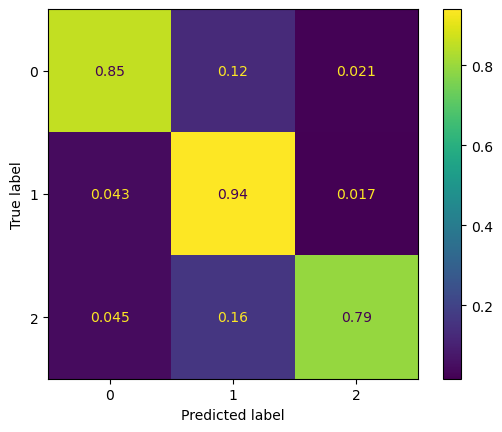

In [14]:
print('accuracy_score:', accuracy_score(all_targets, all_predictions))
print(classification_report(all_targets, all_predictions, digits=4))
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

c = confusion_matrix(all_targets, all_predictions, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()